## BIG QUERY SETUP:

- Create an external table using the Yellow Taxi Trip Records.
- Create a (regular/materialized) table in BQ using the Yellow Taxi Trip Records (do not partition or cluster this table).

### Create an external table using the Yellow Taxi Trip Records.


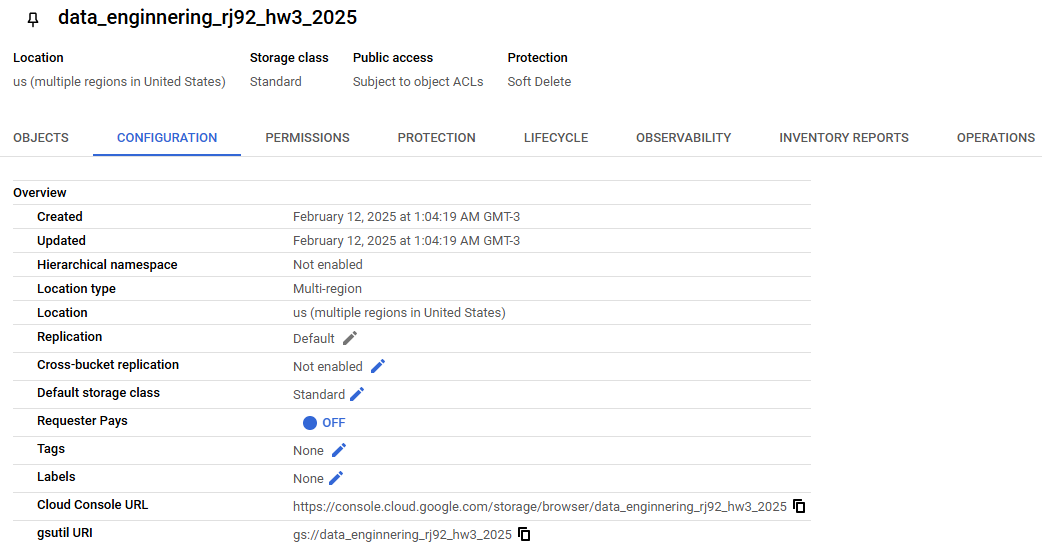

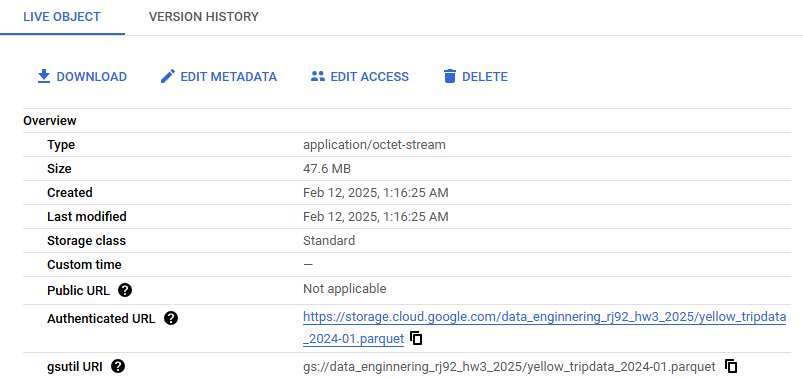

Ejecutar estas query en BigQuery:

```sql
CREATE SCHEMA `data-enginnering-rj92.nytaxi`;
```

```sql
CREATE OR REPLACE EXTERNAL TABLE `data-enginnering-rj92.nytaxi.external_yellow_tripdata`
OPTIONS (
  format = 'PARQUET',
  uris = ['gs://data_enginnering_rj92_hw3_2025/yellow_tripdata_2024-*.parquet']
);
```

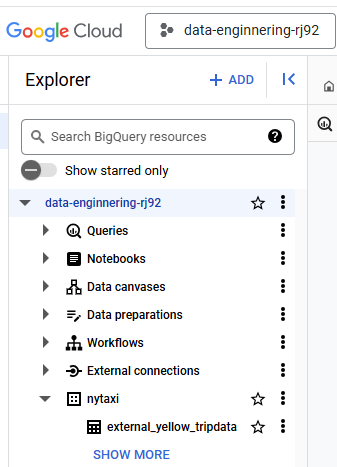

### Create a (regular/materialized) table in BQ using the Yellow Taxi Trip Records (do not partition or cluster this table).

Ejecutar estas query en BigQuery:

```sql
CREATE OR REPLACE TABLE `data-enginnering-rj92.nytaxi.yellow_tripdata`
AS 
SELECT 
* 
FROM `data-enginnering-rj92.nytaxi.external_yellow_tripdata`;
```

## Questions

### Question 1: 

What is count of records for the 2024 Yellow Taxi Data?

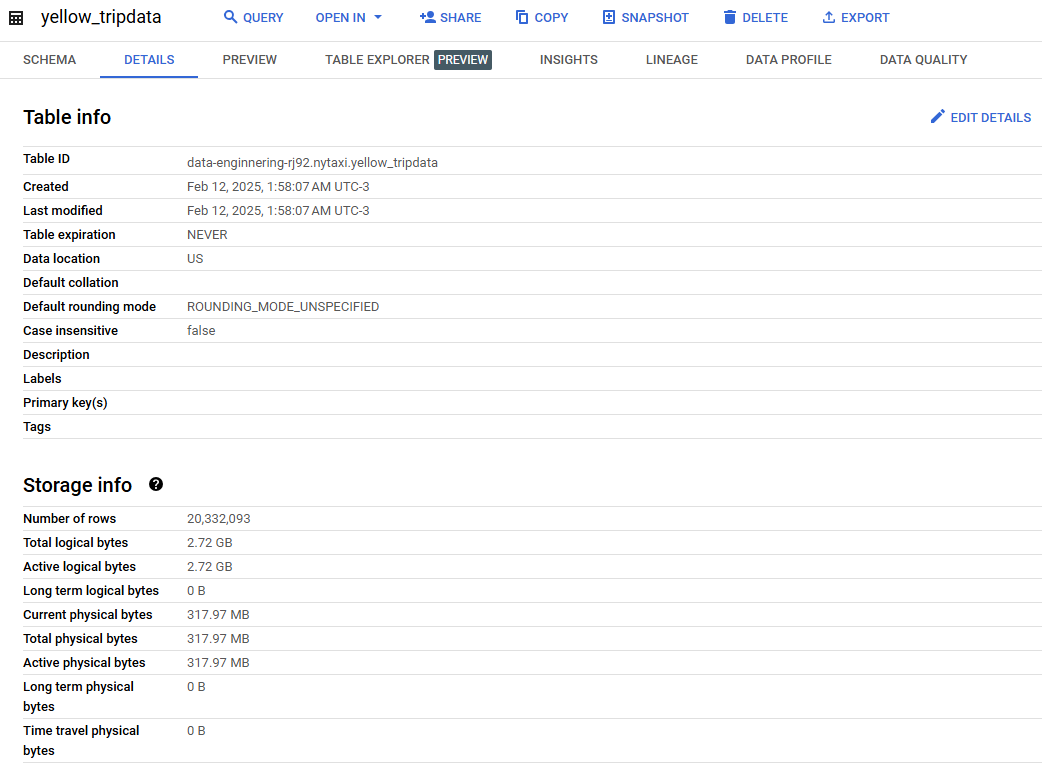

### Question 2:

Write a query to count the distinct number of PULocationIDs for the entire dataset on both the tables.
What is the estimated amount of data that will be read when this query is executed on the External Table and the Table?

**Query tabla externa**
```sql
SELECT 
COUNT(DISTINCT(PULocationID)) COUNT_DISCT_PULocationID
FROM `data-enginnering-rj92.nytaxi.external_yellow_tripdata`;
```

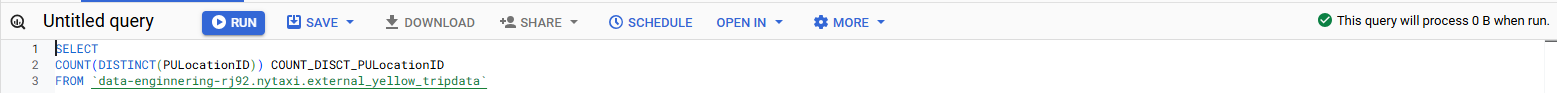

**Query tabla materializada**

```sql
SELECT 
COUNT(DISTINCT(PULocationID)) COUNT_DISCT_PULocationID
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata`;
```

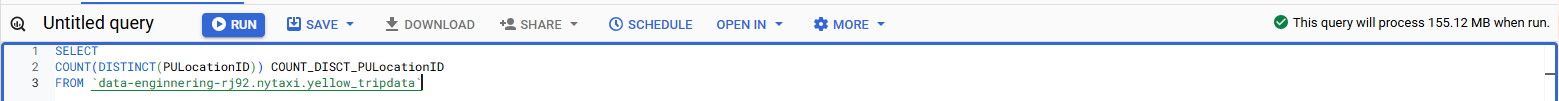

### Question 3:

Write a query to retrieve the PULocationID from the table (not the external table) in BigQuery. Now write a query to retrieve the PULocationID and DOLocationID on the same table. Why are the estimated number of Bytes different?

**Obtener una columna**

```sql
SELECT 
PULocationID
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata`;
```

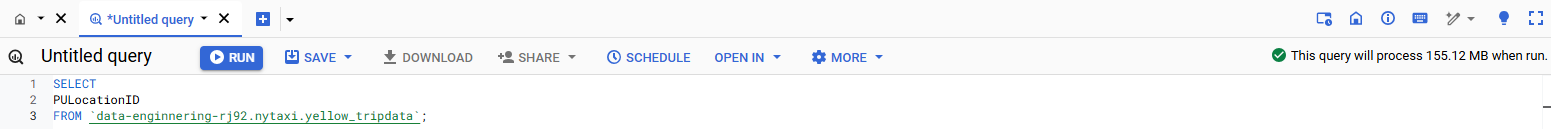

**Obtener dos columnas**

```sql
SELECT 
PULocationID, DOLocationID
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata`;
```

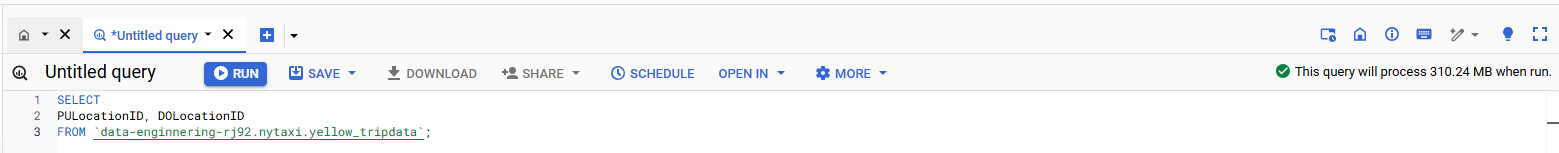

**BigQuery es una base de datos en columnas y solo analiza las columnas específicas solicitadas en la consulta. Consultar dos columnas (PULocationID, DOLocationID) requiere leer más datos que consultar una sola columna (PULocationID), lo que genera una mayor cantidad estimada de bytes procesados.**

### Question 4:

How many records have a fare_amount of 0?

**Ejecutar esta query en BigQuery:**

```sql
SELECT 
COUNT(fare_amount) COUNT_FARE_AMOUNT_0
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata`
WHERE fare_amount = 0;
```

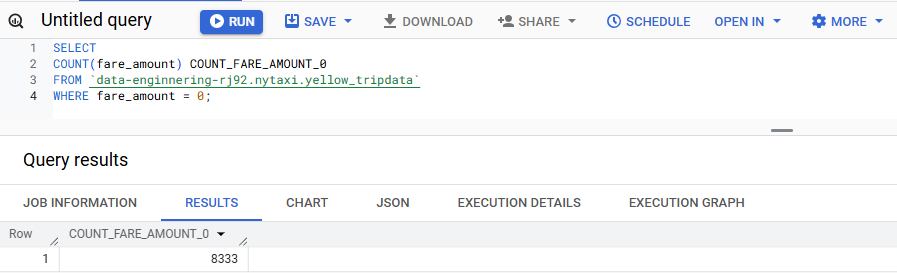

### Question 5:

What is the best strategy to make an optimized table in Big Query if your query will always filter based on tpep_dropoff_datetime and order the results by VendorID (Create a new table with this strategy)

**PARTITION=tpep_dropoff_datetime y CLUSTER=VendorID**

```sql
CREATE OR REPLACE TABLE `data-enginnering-rj92.nytaxi.yellow_tripdata_partitioned_tpep_clustered_vend`
PARTITION BY DATE(tpep_dropoff_datetime)
CLUSTER BY VendorID AS
SELECT * FROM `data-enginnering-rj92.nytaxi.external_yellow_tripdata`;
```

VIEW PARTITIONS
```sql
SELECT table_name, partition_id, total_rows
FROM `data-enginnering-rj92.nytaxi.INFORMATION_SCHEMA.PARTITIONS`
WHERE table_name = 'yellow_tripdata_partitioned_tpep_clustered_vend'
ORDER BY total_rows DESC;
```

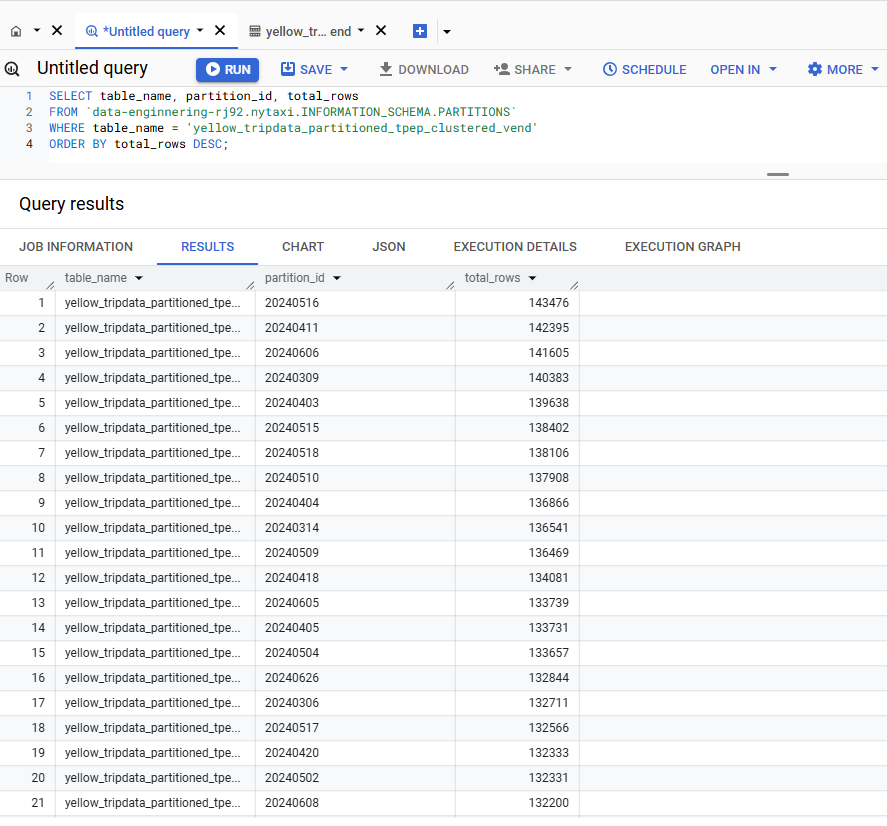

**PARTITION=VendorID y CLUSTER=tpep_dropoff_datetime**

```sql
CREATE OR REPLACE TABLE `data-enginnering-rj92.nytaxi.yellow_tripdata_partitioned_vend_clustered_tpep`
PARTITION BY RANGE_BUCKET(VendorID, GENERATE_ARRAY(0, 5))
CLUSTER BY tpep_dropoff_datetime AS
SELECT * FROM `data-enginnering-rj92.nytaxi.external_yellow_tripdata`;
```

VIEW PARTITIONS
```sql
SELECT table_name, partition_id, total_rows
FROM `data-enginnering-rj92.nytaxi.INFORMATION_SCHEMA.PARTITIONS`
WHERE table_name = 'yellow_tripdata_partitioned_vend_clustered_tpep'
ORDER BY total_rows DESC;
```

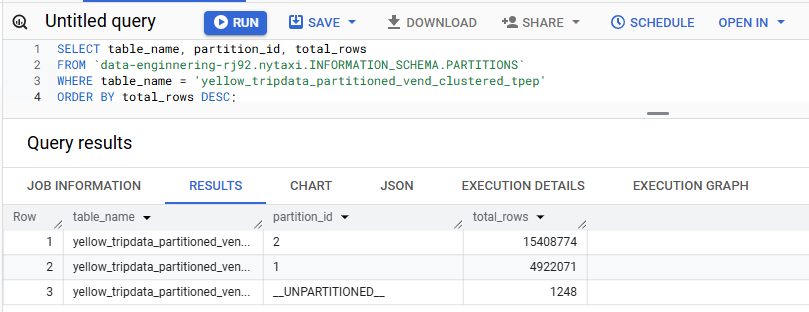

**Partición por tpep_dropoff_datetime y clúster en VendorID**

### Question 6:

Write a query to retrieve the distinct VendorIDs between tpep_dropoff_datetime 2024-03-01 and 2024-03-15 (inclusive)

Use the materialized table you created earlier in your from clause and note the estimated bytes. Now change the table in the from clause to the partitioned table you created for question 5 and note the estimated bytes processed. What are these values?

**Query 1 - sin uso de CAST**

```sql
SELECT 
DISTINCT(VendorID) AS DIST_VENDOR
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata`
WHERE tpep_dropoff_datetime BETWEEN '2024-03-01 00:00:00' AND '2024-03-15 23:59:59';
```

```sql
SELECT 
DISTINCT(VendorID) AS DIST_VENDOR
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata_partitioned_tpep_clustered_vend`
WHERE tpep_dropoff_datetime BETWEEN '2024-03-01 00:00:00' AND '2024-03-15 23:59:59';
```

**Query 2 - con CAST**
```sql
SELECT 
DISTINCT(VendorID) AS DIST_VENDOR
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata`
WHERE CAST(tpep_dropoff_datetime AS DATE) BETWEEN '2024-03-01' AND '2024-03-15';
```

```sql
SELECT 
DISTINCT(VendorID) AS DIST_VENDOR
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata_partitioned_tpep_clustered_vend`
WHERE CAST(tpep_dropoff_datetime AS DATE) BETWEEN '2024-03-01' AND '2024-03-15';
```

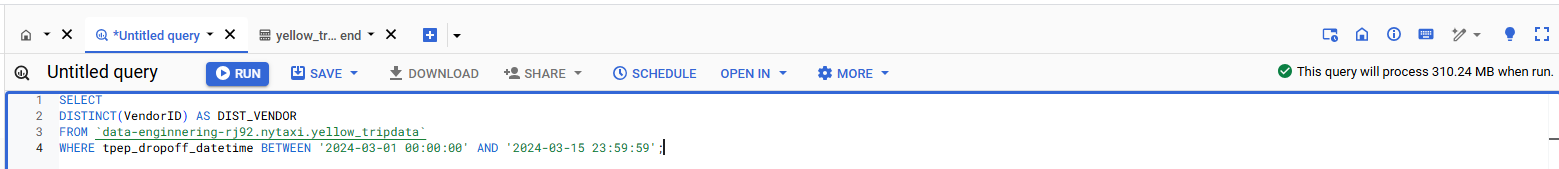

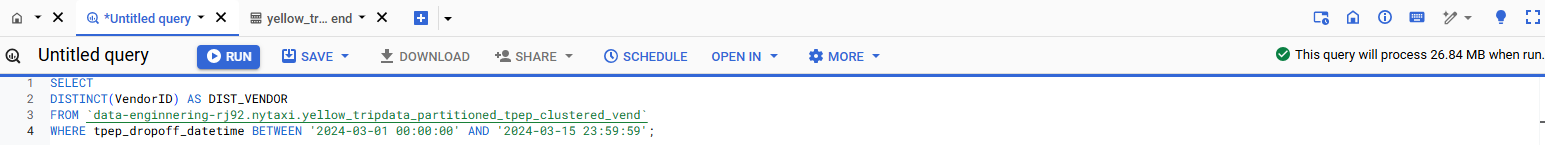

### Question 7:
Where is the data stored in the External Table you created?

**Al crear la tabla externa solo se hace referencia al lugar en donde se encuentra los datos. Los datos no están guardados en el almacen de Bigquery (Colossus). Para el caso de la tabla external_yellow_tripdata la información esta guardad en un GCP Bucket. Esto se puede verificar al ver el detalle de la tabla externa creadad**

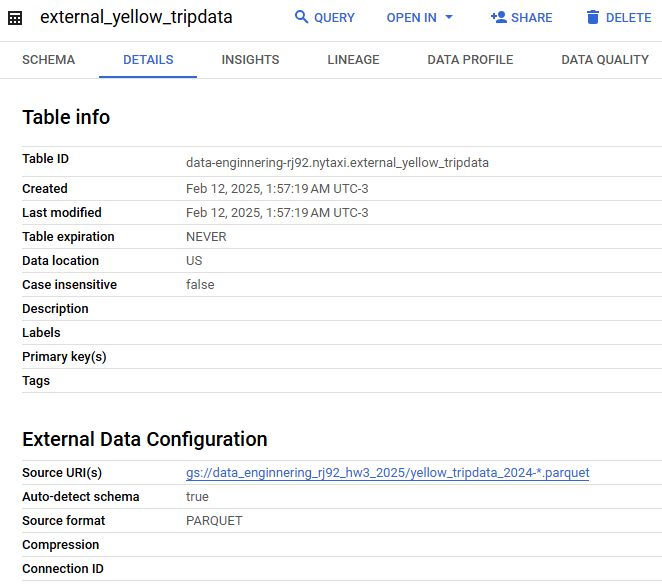

### Question 8:

It is best practice in Big Query to always cluster your data:

**No siempre es aconsejable aplicar particionamiento y clustering en una tabla, ya que en ciertos casos estas técnicas no aportan mejoras y pueden incluso generar efectos contraproducentes.**

No conviene aplicar particionamiento o clustering cuando:
- La tabla es pequeña (menos de 1GB).
- No existen consultas que utilicen filtros específicos sobre una o varias columnas.
- La cardinalidad de los valores es extremadamente alta o, por el contrario, demasiado baja

### (Bonus: Not worth points) Question 9

No Points: Write a SELECT count(*) query FROM the materialized table you created. How many bytes does it estimate will be read? Why?

```sql
SELECT 
count(*) query 
FROM `data-enginnering-rj92.nytaxi.yellow_tripdata`
```

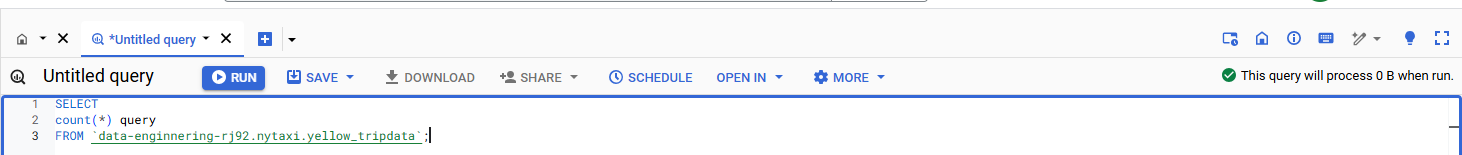

**BigQuery utiliza "metadata caching" para consultas que no requieren escanear datos**